In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyale

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install rdkit-pypi

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.model_selection import KFold, cross_val_score, ParameterGrid
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np
np.int = int
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.utils import shuffle
import shap
shap.initjs()
from PyALE import ale
from scipy.stats import friedmanchisquare
import itertools
from rdkit import Chem
from rdkit.Chem import AllChem

In [24]:
#read input data
df_input = pd.read_csv('input_single.csv', index_col=0)
df_input = df_input.transpose()

# ECFP fingerprints calculation
def compute_ecfp(smiles):
    if smiles is not None:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            return ecfp.ToBitString()
    return None

# Apply the function to the 'SMILES' column and create a new column for ECFP fingerprints

df_input['ECFP main']=df_input['SMILES main compound acid'].apply(lambda x: compute_ecfp(x) if pd.notna(x) else None)

ecfp_main_real = PCA(n_components=1).fit_transform(df_input['ECFP main'].apply(lambda x: pd.Series(map(float, x)) if pd.notna(x) else None))
df_input.insert(loc=df_input.columns.get_loc('SMILES main compound acid'), column='ECFP main real', value=ecfp_main_real)

df_input = df_input.transpose()

#filter input data
indices_to_remove_input = ['experimentalist', 'name main compund acid', 'c total', 'SMILES main compound acid', 'name 2nd compound acid', 'SMILES 2nd compound acid', 'name 3rd compound acid', 'SMILES 3rd compound acid', 'time', 'cathode material', 'cathode area [cm^2 ]', 'anode material']
filtered_input = df_input.drop(indices_to_remove_input)
filtered_input = filtered_input.fillna(0) # fill  empty cells with 0
filtered_input = filtered_input.transpose() # change positions of columns and rows
filtered_input = filtered_input.loc[:, :'anode tafel slope pH7 0.25M Na2SO4 [mAcm-2V-1]'] # remove columns after certain column
#print(filtered_input)

#filter output data
df_output = pd.read_csv('input_single.csv', index_col=0)
filtered_output = df_output.loc['acid conversion [%]':, :,] # remove columns after certain column
filtered_output = filtered_output.fillna(0) # fill  empty cells with 0
filtered_output = filtered_output.transpose() # change positions of columns and rows
#print(filtered_output)

output = 'selectivity alkane [%]'
output_name = 'selectivity [%]' # for correlation matrix
X = filtered_input.values
Y = filtered_output[output].values
X = X.astype(float) # change to float for knn
Y = Y.astype(float) # change to float for knn
print(len(filtered_input.iloc[0]))
#print(filtered_input.iloc[0])
features = []
feature_names = ['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment','dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope']
x=0
for i in feature_names:
    features.append(x)
    x += 1
print(len(feature_names))    
#print(features)
#print(len(feature_names))
random_state_counter = 49

25
25


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)
knn_regressor = Pipeline([
    ('scaler_std', StandardScaler()),
    ('scaler_minmax', MinMaxScaler()),  
    ('knn', KNeighborsRegressor(n_neighbors=1, weights='distance', p=1))
])

knn_regressor.fit(X_train, Y_train)

Y_predict_train_knn = knn_regressor.predict(X_train)
Y_predict_test_knn = knn_regressor.predict(X_test)


mse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn)
rmse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn, squared=False)
r2_train_knn = r2_score(Y_train, Y_predict_train_knn)

mse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn)
rmse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn, squared=False)
r2_test_knn = r2_score(Y_test, Y_predict_test_knn)

print("MSE on train set:", mse_train_knn )
print("RMSE on train set:", rmse_train_knn)
print("R2 on train set:", r2_train_knn)
print("MSE on test set:", mse_test_knn )
print("RMSE on test set:", rmse_test_knn)
print("R2 on test set:", r2_test_knn)


MSE on train set: 0.0
RMSE on train set: 0.0
R2 on train set: 1.0
MSE on test set: 13.225295305253029
RMSE on test set: 3.636659910584578
R2 on test set: 0.9788705634668297


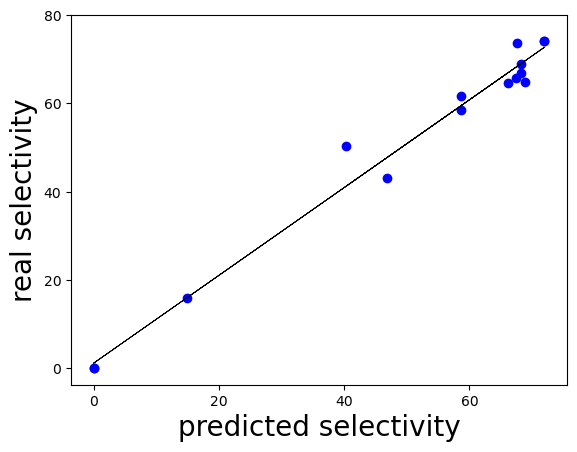

In [17]:
# Linear fit
slope, intercept = np.polyfit(Y_predict_test_knn, Y_test, 1)
fit_line = slope * Y_predict_test_knn + intercept

plt.plot(Y_predict_test_knn, fit_line, color='black', linestyle='-', label='Linear Fit', lw=0.5)
plt.scatter(Y_predict_test_knn, Y_test, color='blue', label='Scatter Points')
#plt.title('Scatter Plot of Y_train vs Y_test')
plt.xlabel('predicted selectivity', fontsize=20)
plt.ylabel('real selectivity', fontsize=20)
ticks_interval = 20
if int(min(Y_predict_test_knn)) > int(min(Y_test)):
    min_value = int(min(Y_test))
else:
    min_value = int(min(Y_predict_test_knn))
plt.xticks(np.arange(min_value, int(max(Y_predict_test_knn)) + 7, ticks_interval))
plt.yticks(np.arange(min_value, int(max(Y_test)) + 7, ticks_interval))
#plt.xlim([2, 36])  # Set x-axis range
#plt.ylim([2, 36])  # Set y-axis range
plt.show()

26
['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment', 'dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope', 'selectivity [%]']


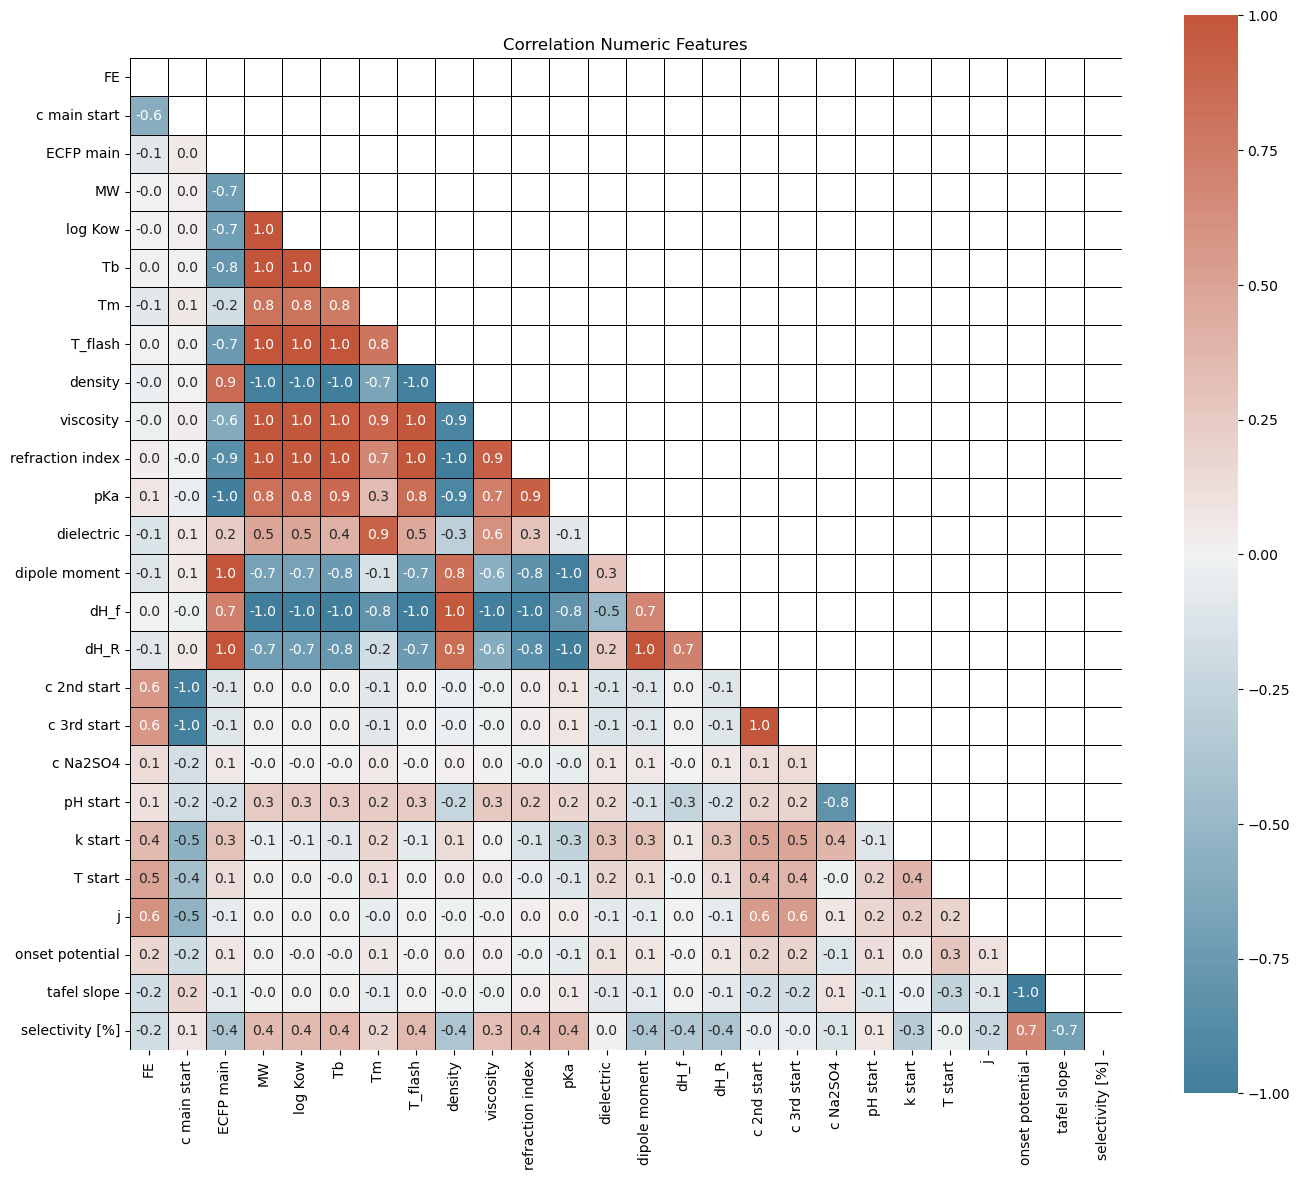

In [18]:
# correlation matrix
feature_namesXY = feature_names.copy()

feature_namesXY.append(output_name)

print(len(feature_namesXY))
print(feature_namesXY)


df_XY = filtered_input.copy()
df_XY[output_name] = filtered_output[output]
df_XY.columns = feature_namesXY # change name

corr_df = df_XY.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.1f',
    ax=ax
)
ax.set(title='Correlation Numeric Features');

In [19]:
# SHAPLEY values
#explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
#instance_index = 7  # Replace with the index of the instance you want to explain
#shap_value = explainer.shap_values(X_test[instance_index])
#shap.force_plot(explainer.expected_value, shap_value, X_test[instance_index], feature_names=feature_names)

In [26]:
shap_data = X
explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
shap_values = explainer.shap_values(shap_data)

100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


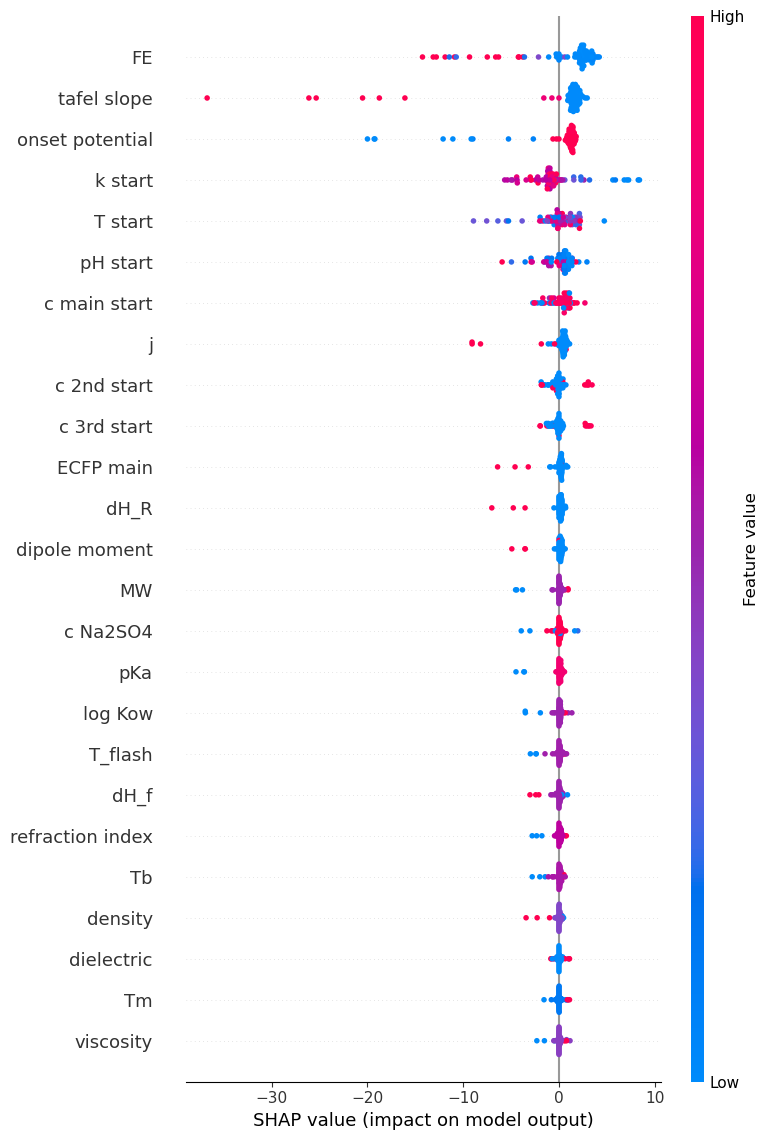

In [21]:
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, max_display=25)

100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


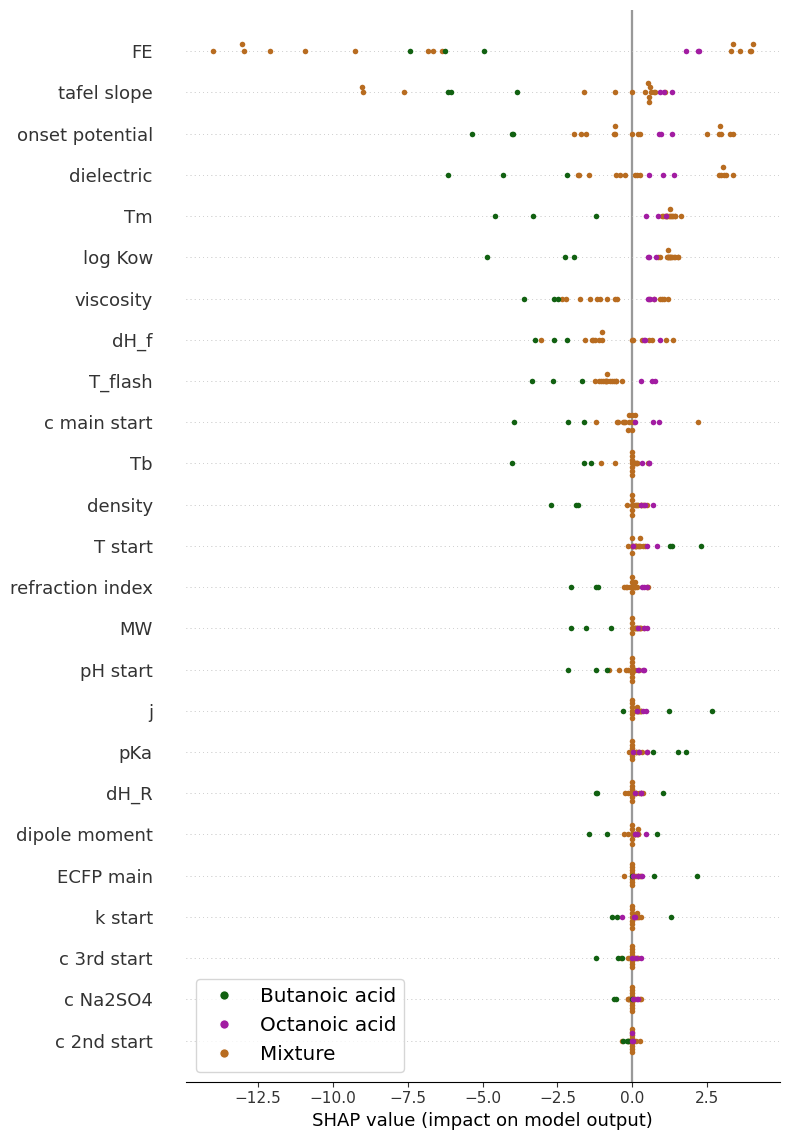

In [28]:
# show different acids and mixture
input_C4_acid = filtered_input.loc['21084':'21086']
input_C8_acid = filtered_input.loc['21093':'21095']
input_mixture = filtered_input.loc['21098':'21114']

color_C4='#116111'
color_C8='#a21ca2'
color_mixture='#b86c20'

X_mixture = input_mixture.values
X_mixture = X_mixture.astype(float) # change to float for knn

shap_values_mixture = explainer.shap_values(X_mixture)

shap.summary_plot(shap_values_mixture,
                  feature_names=feature_names,
                  max_display=25,
                  show=False,
                  #sort=None,
                  color_bar=None,
                  color_bar_label=None,               
                  cmap=None,
                  color=color_mixture, #purple
                  #axis_color='#111111'
                 )


X_C4 = input_C4_acid.values
X_C4 = X_C4.astype(float) # change to float for knn

shap_values_C4 = explainer.shap_values(X_C4)

shap.summary_plot(shap_values_C4,
                  feature_names=feature_names,
                  max_display=25,
                  show=False,
                  #sort=None,
                  color_bar=None,
                  color_bar_label=None,               
                  cmap=None,
                  color=color_C4, #green
                  #axis_color='#111111'
                 )


X_C8 = input_C8_acid.values
X_C8 = X_C8.astype(float) # change to float for knn

shap_values_C8 = explainer.shap_values(X_C8)

shap.summary_plot(shap_values_C8,
                  feature_names=feature_names,
                  max_display=25,
                  show=False,
                  #sort=None,
                  color_bar=None,
                  color_bar_label=None,               
                  cmap=None,
                  color=color_C8, #purple
                  #axis_color='#111111'
                 )


# Manually add a legend with enforced colors
legend_labels = ['Butanoic acid', 'Octanoic acid', 'Mixture']

# Specify the colors you want to enforce
enforced_colors = [color_C4, color_C8, color_mixture]

# Create a legend with custom symbols (bullets) and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, enforced_colors)]
legend = plt.legend(handles=legend_handles, loc='lower left', markerscale=0.7, fontsize='x-large')


# Show the plot
plt.show()

In [ ]:
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, max_display=5, plot_size = (6, 4))

In [ ]:
#print(shap_values)
columns_to_drop = ['FE', 'onset potential', 'tafel slope']
df_shap_values = pd.DataFrame(shap_values, columns = feature_names)
df_shap_values = df_shap_values.drop(columns_to_drop, axis=1)
shap_values_selected = df_shap_values.values

df_shap_data = pd.DataFrame(shap_data, columns = feature_names)
df_shap_data = df_shap_data.drop(columns_to_drop, axis=1)
shap_data_selected = df_shap_data.values

#df_shap_values
feature_names_selected = df_shap_values.columns.values

shap.summary_plot(shap_values_selected, shap_data_selected, feature_names=feature_names_selected, max_display=25, plot_size = (18, 8)
)

In [ ]:
# Create a SHAP dependence plot

feature_index=24
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

feature_index=0
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

feature_index=23
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

#for i in features:
    #shap.dependence_plot(i, shap_values, shap_data, feature_names=feature_names)

In [ ]:
df_test=pd.DataFrame({"test": Y_test, "prediction": Y_predict_test_knn})
print(df_test)

In [ ]:
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax#, line_kw={"color": "green"}
                                                 )

In [ ]:
#  Individual conditional expectation (ICE) plot (single instead of averages) 
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', ax=ax#, line_kw={"color": "green"}
                                                 )

In [ ]:
# cICE (centered ICE) and PDP
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)


for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', centered=True, ax=ax#, line_kw={"color": "green"}
                                                 )

In [ ]:
df_train_X = pd.DataFrame(X_train, columns=features)
df_train_Y = pd.DataFrame(Y_train, columns=[output_name])

# get ALE plot

for i in features:
    if i % 5 == 0:
        fig, ax = plt.subplots(ncols=ncols, figsize=(45,6), sharey=True)
        for axis in ax.flatten():
            axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
        ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[0]
        )
        ax[0].set_ylabel('ALE total yield')
        ax[0].set_xlabel(feature_names[i])
        ax[0].set_title('')
    else:
        if (i+1) % 5 == 0:
            ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[1]
            )
            ax[1].set_ylabel('')
            ax[1].set_xlabel(feature_names[i])
            ax[1].set_title('')
        else:
            if (i+2) % 5 == 0:
                ale_eff = ale(
                X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                fig=fig, ax=ax[2]
                )
                ax[2].set_ylabel('')
                ax[2].set_xlabel(feature_names[i])
                ax[2].set_title('')
            else:
                if (i+3) % 5 == 0:
                    ale_eff = ale(
                    X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                    fig=fig, ax=ax[3]
                    )
                    ax[3].set_ylabel('')
                    ax[3].set_xlabel(feature_names[i])
                    ax[3].set_title('')
                else:
                    ale_eff = ale(
                    X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                    fig=fig, ax=ax[4]
                    )
                    ax[4].set_ylabel('')
                    ax[4].set_xlabel(feature_names[i])
                    ax[4].set_title('')
    

In [ ]:
selected_features = [0, 18, 20, 21, 23, 24]
ale_ylabel = 'selectivity centered'


fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(16,12), sharey=True)

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[0], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,0]
)
ax[0,0].set_ylabel(ale_ylabel)
ax[0,0].set_xlabel(feature_names[0])
ax[0,0].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[23], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,1]
)
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('onset potential [V]')
ax[0,1].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[24], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,2]
)
ax[0,2].set_ylabel('')
ax[0,2].set_xlabel('tafel slope [V]')
ax[0,2].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[21], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,0]
)
ax[1,0].set_ylabel(ale_ylabel)
ax[1,0].set_xlabel('T start [°C]')
ax[1,0].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[18], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,1]
)
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('c Na2SO4 [mmol/L]')
ax[1,1].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[20], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,2]
)
ax[1,2].set_ylabel('')
ax[1,2].set_xlabel('k start [mS/cm]')
ax[1,2].set_title('')

In [ ]:
# 2D ale plots


#ax.set_ylabel('ALE total yield')
#ax.set_xlabel(feature_names[i])
#ax.set_title('')



In [ ]:
# permutation feature importance on test data

# Initialize list
row_list = []

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_test)
baseline_mse = mse(Y_test, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_test.shape[1])


runs = 500

for j in range(runs):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    # Create a new row in the DataFrame
    row_list.append(dict(zip(feature_names, feature_importances)))
    

    #df_feature_importances.loc[len(df_feature_importances)] = feature_importances
    df_feature_importances=pd.DataFrame(row_list, columns=feature_names)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = feature_names

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(df_feature_importances.index)[sorted_indices]  # Use feature_names array

bar_width = 0.7  # Adjust the width of the bars
bar_spacing = 0.1  # Adjust the spacing between bars

plt.barh(np.arange(len(sorted_indices)), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices],
         height=bar_width, align='center', alpha=0.7, capsize=5)
plt.yticks(np.arange(len(sorted_indices)), sorted_feature_names, fontsize=20)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance', fontsize=20)

# Adjust the xlim to make room for bar spacing
plt.xlim(0, max(mean_values) + 0.3)

# Adjust the figure size to accommodate spacing
fig = plt.gcf()
fig.set_size_inches(8, len(sorted_indices) * (bar_width + bar_spacing))

plt.show()

In [ ]:
plt.rc('axes', labelsize=20) #size of laabel axis

# Choose the top 6 features
top_feature_indices = sorted_indices[-5:]
top_feature_names = sorted_feature_names[-5:]

plt.barh(range(len(top_feature_indices)), mean_values[top_feature_indices], xerr=std_dev_values[top_feature_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(len(top_feature_indices)), top_feature_names)  # Use top_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.xticks(np.arange(0, 0.81, 0.2))
plt.show()

In [ ]:
# permutation feature importance on training data

# Initialize list
row_list = []

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_train)
baseline_mse = mse(Y_train, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_train.shape[1])


runs = 500

for j in range(runs):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    # Create a new row in the DataFrame
    row_list.append(dict(zip(feature_names, feature_importances)))
    

    #df_feature_importances.loc[len(df_feature_importances)] = feature_importances
    df_feature_importances=pd.DataFrame(row_list, columns=feature_names)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = feature_names

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()